## Cryer sphere: radial compression of a saturated poroelastic sphere

### Problem description

We validate the capacity of the model to reproduce the Mandel-Cryer effect. This phenomenon involves a non-monotonous pressure evolution under the constant mechanical load, which can be reproduced only by full poroelastic coupling. 

The Cryer's problem involves a homogeneous permeable poroelastic sphere of radius $R$, saturated with fluid, initially at zero pressure, as depicted in figure below. The fluid can freely drain from the surface. When subjected to radial loading $F$ applied at its surface, the sphere undergoes  instantaneous compression. The resulting undrained response leads to a uniform pressure build-up of the amplitude $p_0$ throughout the sphere. Subsequently, fluid pressure begins to diffuse from the surface, causing softening in the outer layer of rock. This decrease in stiffness leads to the stress redistribution across the sphere, leading to further compression of the inner region still experiencing undrained conditions. At the centre of the sphere,   two opposing effects occur: pressure diffusion and pressure build-up due to continuous compression of the inner part. Initially, pressure build-up prevails, but at later stages, diffusion dominates, causing pressure to dissipate towards zero. 

A closed form analytical solution to this problem is available in "Theory of consolidation" by Verruijt, 2010 and "Poroelasticity" by Cheng, 2016. 


![sphere](./images/sphere.png)

In [1]:
import akantu as aka
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

from akantu_geomechanical_solver import AkantuGeomechanicalSolver
from akantu_geomechanical_solver import IterativeOptions
sys.path.append(os.path.join(sys.path[0], '..', 'analytical_solutions'))
import analytical_solutions as an_sol


### Material and simulation parameters

In [2]:
# geometric parameters
ball_r = 1  # [m] sphere radius
h = 0.1   # [m] element size

# material parameters
phi_0 = 0.05  # [-] porosity
K = 10  # [GPa] bulk modulus
G = 6  # [GPa] shear modulus consistent with K and Poisson
poisson = (3 * K - 2 * G) / 2 / (3 * K + G) # [-] Poisson ratio
E = 9 * K * G / (3 * K + G) # [GPa] Young modulus
alpha = 0.9  # [-] Biot's coefficient
one_over_M = 3.05e-2  # [1/GPa] Biot's modulus
k = 1e-18  # [m2] permeability
mu = 8.9e-13  # [GPa s] viscosity
load = 5 # [GPa] radial compression 
S = one_over_M + 3 * alpha**2 / (3 * K + 4 * G) # storage coefficient
c_v = k / mu / S # generalized consolidation coefficient (Cheng's book, p.198)
final_time = ball_r * ball_r / c_v  # [s] final time
nb_timesteps = 50
timestep = final_time / nb_timesteps
times = np.linspace(0, final_time, nb_timesteps + 1)
m_v = 1 / (K + 4 / 3 * G) # [1/GPa] confined compressibility of the porous medium (see Haagenson et al. 2020)

beta_s = 1.0e-2 # [1/GPa] compressibility of solid particles
beta_m = 1.0e-1 # [1/GPa] compressibility of the porous media
beta_f = 4.4e-1  # [1/GPa] compressibility of the fluid
S_eps = (alpha - phi_0) * beta_s + phi_0 * beta_f # [1/GPa] drained storage coefficient (see Haagenson et al. 2020)

### Creating a material file for Akantu

In this tutorial we will consider an poroelastic constitutive law.

The following file *material.dat* describes such a constitutive law, which we write and then load thanks to *Akantu*'s parsing routines.

In [3]:
material_file = f"""
material elastic [
    name = rock
    E   = {E}   # young's modulus [GPa]
    nu  = {poisson}      # poisson's ratio
]

model heat_transfer_model [
        density = 1  #kg/m3
        conductivity = [[{k/mu}, 0, 0], \
                        [0,  {k/mu}, 0], \
                        [0,  0, {k/mu}]] # m2/(GPa s)
        capacity = {one_over_M}        # 1/GPa
]
"""
# writing the material file
open('material.dat', 'w').write(material_file)

# reading the material file
material_file = 'material.dat'
aka.parseInput(material_file)

### Mesh reading and model creation
Here, we read the mesh produced in *geometry.py* script. Due to the model symmetry, we consider only 1/8th of the full sphere.

Later, we create *SolidMechanicsModel* and *HeatTransferModel* to be coupled through the geomechanical simulator. The name *HeatTransferModel* is a legacy feature of Akantu. By this name any model governed by the diffusion equation is meant. In our case, it is the pressure diffusion. Consequently, the native variable of the *HeatTransferModel* and *HeatTransferInterfaceModel* is temperature. We however understand that for the pressure diffusion, the primary variable is pressure. This inconsitency in names is expected to be corrected in future versions of Akantu.

In [4]:
# reading the mesh
dim = 3
mesh_file = "sphere_coarse.msh"
mesh = aka.Mesh(dim)
mesh.read(mesh_file)

mesh.distribute()

rock_model = aka.SolidMechanicsModel(mesh)
flow_model = aka.HeatTransferModel(mesh)

rock_model.initFull(_analysis_method=aka._static)
flow_model.initFull(_analysis_method=aka._implicit_dynamic)
flow_model.setTimeStep(timestep)

### Applying boundary conditions
To enforce symmetry of the problem, we apply zero out-of-plane displacements on the three planar surfaces of the 1/8th of the sphere.

Later, we apply radial compression on the spherical surface of the model.

In [5]:
 # set the displacement/Dirichlet boundary conditions
rock_model.applyBC(aka.FixedValue(0.0, aka._x), "left")
rock_model.applyBC(aka.FixedValue(0.0, aka._y), "back")
rock_model.applyBC(aka.FixedValue(0.0, aka._z), "bottom")

# set the force/Neumann boundary conditions
surface_stress = np.eye(dim)
surface_stress *= load
rock_model.applyBC(aka.FromStress(surface_stress), "surface")

### Configuring model solvers

In [6]:
flow_solver = flow_model.getNonLinearSolver()
flow_solver.set("max_iterations", 10)
flow_solver.set("threshold", 1e-7)
flow_solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

rock_solver = rock_model.getNonLinearSolver()
rock_solver.set("max_iterations", 20)
rock_solver.set("threshold", 1e-6)
rock_solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)

### Setting up the geomechanical solver

In [7]:
it_options = IterativeOptions(
    pcg_maxiterations=50,
    newton_maxiterations=100,
    f_rtol=1e-9,
    f_rock_tol=1e-5,
    f_flow_tol=1e-8)
solver = AkantuGeomechanicalSolver(
    rock_model, flow_model, alpha, dump_iterations=False, update_stiffness=False)

Prepare the output array for values of the pressure at the centre of the sphere and the arrays with initial guess for the PCG solver. We use zero values as the initial guess.

In [8]:
# prepare the initial guess arrays for the PCG solver
nb_nodes = mesh.getNbNodes()
delta_u_0 = np.zeros([nb_nodes, dim])
delta_p_0 = np.zeros([nb_nodes, 1])

# identify the central node for outputing the pressure
central_node = 0
central_node_found = False
nodes = mesh.getNodes()
node_flags = mesh.getNodesFlags()
for node_nb in range(mesh.getNbNodes()):
    if (np.allclose(nodes[node_nb], [0, 0, 0]) and node_flags[node_nb] == np.uint8(aka._normal)):
        central_node = node_nb
        central_node_found = True

central_pressure = np.zeros(nb_timesteps + 1)

## Solve the undrained response

First we apply the analytical solution to the undrained pressure and solve for the resulting displacements.

In [9]:
# apply the analytical solution for pressure of the undrained response to the model
p_0_an = an_sol.p_0_cryer(alpha, K, S_eps, load)
pressure = flow_model.getTemperature()
blocked_dofs_p = flow_model.getBlockedDOFs()
pressure.fill(p_0_an)
blocked_dofs_p.fill(True)

# solve the displacement part of the undrained response first
cvged = solver.solve_step(delta_u_0, delta_p_0, it_options)
if not cvged:
    raise Exception(
        f"Time step solver did not converge")

if central_node_found == True:
    central_pressure[0] = pressure[central_node]


Newton 0 iteration: p res 0.0 vs 1e-08; u res 0.3588627599411742 vs 1e-05; u res full 1.1544846160907833

iteration 0 
r2 0.0 vs. max[r0 7.643698220149578e-06 * 1e-09, rtol 1e-08] 
dx2 0.0

Newton 1 iteration: p res 0.0 vs 1e-08; u res 5.927710458711349e-16 vs 1e-05; delta u norm 0.3366095844430944; delta p norm 0.0


### Boundary conditions for the flow model
Class below defines a functor to fix scalar variable. It had to be defined here as there is no such native functor in Akantu.

In [10]:

class FixedPressure (aka.DirichletFunctor):
    def __init__(self, value):
        super().__init__()
        self.value = value

    def __call__(self, node, flags, primal, coord):
        # sets the blocked dofs vector to true in the desired axis
        flags[0] = True
        primal[0] = self.value

In [11]:
# applying fixed pressure at the top
blocked_dofs_p.fill(False)
flow_model.applyBC(FixedPressure(0.), "surface")

for i in range(nb_timesteps):
    print(f"\nSolving time step {i}", flush=True)

    cvged = solver.solve_step(delta_u_0, delta_p_0, it_options)
    if not cvged:
        raise Exception(
            f"Time step solver did not converge")

    if central_node_found == True:
        central_pressure[i + 1] = pressure[central_node]



Solving time step 0

Newton 0 iteration: p res 6.038256503804886e-06 vs 1e-08; u res 0.7483797121658723 vs 1e-05; u res full 1.4788843101807938

iteration 0 
r2 8.093512407502806e-07 vs. max[r0 8.446944817615678e-06 * 1e-09, rtol 1e-08] 
dx2 2.9845241665230824

iteration 1 
r2 3.571501963497959e-07 vs. max[r0 8.446944817615678e-06 * 1e-09, rtol 1e-08] 
dx2 1.052458837246684

iteration 2 
r2 1.3074475178818406e-07 vs. max[r0 8.446944817615678e-06 * 1e-09, rtol 1e-08] 
dx2 0.43670299312815297

iteration 3 
r2 4.385220456965777e-08 vs. max[r0 8.446944817615678e-06 * 1e-09, rtol 1e-08] 
dx2 0.1750414808883194

iteration 4 
r2 1.539929571114442e-08 vs. max[r0 8.446944817615678e-06 * 1e-09, rtol 1e-08] 
dx2 0.05007507628122571

iteration 5 
r2 4.796874026236627e-09 vs. max[r0 8.446944817615678e-06 * 1e-09, rtol 1e-08] 
dx2 0.013950440574497881

Newton 1 iteration: p res 4.796874026235757e-09 vs 1e-08; u res 5.155693128620068e-16 vs 1e-05; delta u norm 0.25635970149114246; delta p norm 3.617

## Plotting pressure at the centre of the sphere vs the analytical solution

/Users/emil/Documents/work/postdoc_work/poroel_akantu/for_git/examples/cryer_sphere/../analytical_solutions/analytical_solutions.py:176: RuntimeWarning: invalid value encountered in divide
  sin_vec = (np.sin(roots) - roots) / (


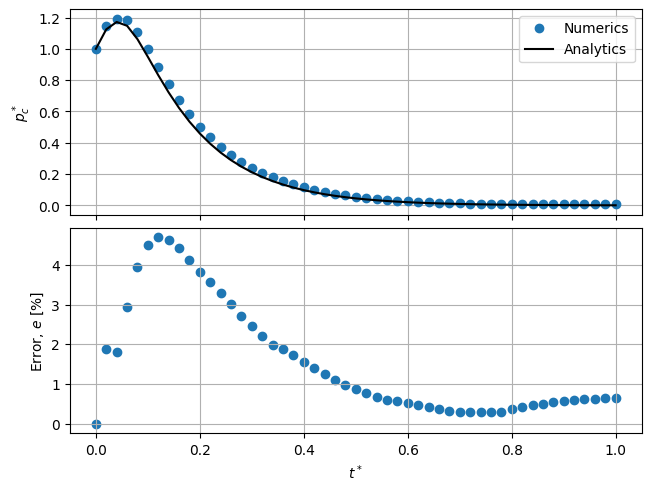

In [12]:
if central_node_found:
    # analytical solution for last time step in pressure
    times_star = c_v * times / ball_r / ball_r
    p_analytic = np.zeros(times.size)
    p_analytic[0] = p_0_an
    p_analytic[1:] = an_sol.p_cryer(
        alpha, K, S_eps, G, m_v, p_0_an, times[1:], c_v, ball_r, 100)

    fig2, (ax6, ax7) = plt.subplots(2, 1, layout="constrained")
    ax6.plot(times_star, central_pressure / p_0_an,
            linestyle=' ', marker="o", label='Numerics')
    ax6.plot(times_star, p_analytic / p_0_an, color='k', label='Analytics')
    ax6.set_ylabel(r'$p^*_c$')
    ax6.legend(loc='best')
    ax6.xaxis.set_tick_params(labelbottom=False)
    ax6.grid()

    ax7.scatter(times_star, abs(p_analytic - central_pressure) /
            np.max(p_analytic) * 100)
    ax7.set_xlabel(r'$t^*$')
    ax7.set_ylabel('Error, $e$ [%]')
    ax7.grid()
    plt.show()


In [13]:
#"Absolute error " + str(np.max(abs(p_analytic - central_pressure)))
#"Relative error " + str(np.max(abs(p_analytic - central_pressure) / np.max(p_analytic) * 100))
np.allclose(p_analytic, central_pressure, rtol = 4.7)

True

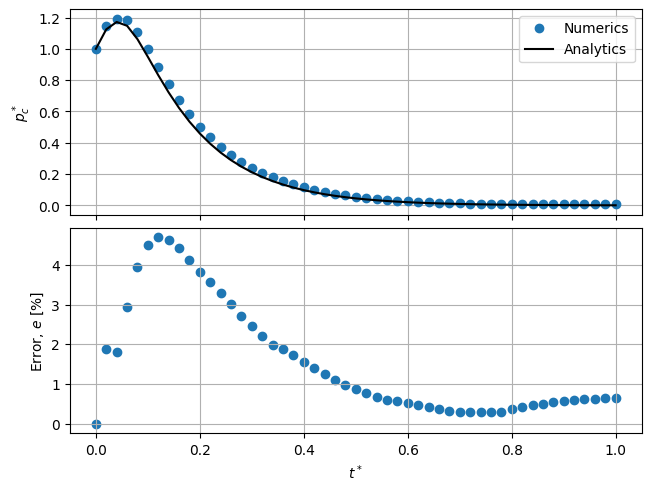

In [14]:

    fig2, (ax6, ax7) = plt.subplots(2, 1, layout="constrained")
    ax6.plot(times_star, central_pressure / p_0_an,
            linestyle=' ', marker="o", label='Numerics')
    ax6.plot(times_star, p_analytic / p_0_an, color='k', label='Analytics')
    ax6.set_ylabel(r'$p^*_c$')
    ax6.legend(loc='best')
    ax6.xaxis.set_tick_params(labelbottom=False)
    ax6.grid()

    ax7.scatter(times_star, abs(p_analytic - central_pressure) /
            np.max(p_analytic) * 100)
    ax7.set_xlabel(r'$t^*$')
    ax7.set_ylabel('Error, $e$ [%]')
    ax7.grid()
    plt.show()
